In [1]:
import os
import sys
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
from matplotlib.ticker import MultipleLocator
import nibabel as nib
import pickle

os.chdir('/home/rfpred')
sys.path.append('/home/rfpred')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode')

print(sys.path)
%pwd

['/home/rfpred/notebooks', '/home/rfpred/envs/rfenv/lib/python311.zip', '/home/rfpred/envs/rfenv/lib/python3.11', '/home/rfpred/envs/rfenv/lib/python3.11/lib-dynload', '', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages', '/home/rfpred', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode']


'/home/rfpred'

In [2]:
from funcs.imgproc import get_imgs_designmx, rms_all, feature_df, show_stim, get_rms_contrast, get_rms_contrast_lab, get_contrast_df, get_img_prf
from funcs.rf_tools import get_mask, css_gaussian_cut, make_circle_mask, make_visrois_dict, write_prf_dict
from funcs.utility import print_dict_structure, print_large, get_zscore, hypotheses_plot, multiple_regression


In [3]:
n_subjects = len(os.listdir('/home/rfpred/data/natural-scenes-dataset/nsddata/ppdata'))
vismask_dict = make_visrois_dict(vox_count = 'y', bin_check = 'n', n_subjects=n_subjects)
prf_dict = write_prf_dict(binary_masks = vismask_dict)

Subject 1
V1_mask
Non-zero voxels in V1_mask: 7887
V2_mask
Non-zero voxels in V2_mask: 8296
V3_mask
Non-zero voxels in V3_mask: 7022
V4_mask
Non-zero voxels in V4_mask: 3976
Subject 2
V1_mask
Non-zero voxels in V1_mask: 6476
V2_mask
Non-zero voxels in V2_mask: 6376
V3_mask
Non-zero voxels in V3_mask: 6236
V4_mask
Non-zero voxels in V4_mask: 2887
Subject 3
V1_mask
Non-zero voxels in V1_mask: 7358
V2_mask
Non-zero voxels in V2_mask: 6721
V3_mask
Non-zero voxels in V3_mask: 5316
V4_mask
Non-zero voxels in V4_mask: 2486
Subject 4
V1_mask
Non-zero voxels in V1_mask: 5119
V2_mask
Non-zero voxels in V2_mask: 5088
V3_mask
Non-zero voxels in V3_mask: 4669
V4_mask
Non-zero voxels in V4_mask: 2790
Subject 5
V1_mask
Non-zero voxels in V1_mask: 6502
V2_mask
Non-zero voxels in V2_mask: 6309
V3_mask
Non-zero voxels in V3_mask: 5383
V4_mask
Non-zero voxels in V4_mask: 3184
Subject 6
V1_mask
Non-zero voxels in V1_mask: 6479
V2_mask
Non-zero voxels in V2_mask: 6905
V3_mask
Non-zero voxels in V3_mask: 71

In [4]:
# Load in the RMS contrast values for each image
all_rms = pd.read_pickle('all_rms_lab_df')
all_rms

rms
0      24.850763
1      66.215949
2      15.592134
3      15.113406
4      32.931833
...          ...
72995  32.597843
72996  19.921272
72997  54.109564
72998  28.464819
72999  18.567823

[73000 rows x 1 columns]

In [5]:
# Load in the design matrix
dmx = get_imgs_designmx()

# Subject specific object with the correct sequence of RMS contrast values per image.
rms_subj01 = feature_df(subject = 'subj01', feature = 'rms', feat_per_img = all_rms, designmx = dmx) 

print(rms_subj01)

       img_no        rms
0       46002  25.471033
1       61882  22.462335
2         828  18.877597
3       67573  42.634550
4       16020  16.612092
...       ...        ...
29995   13773  22.456342
29996   66767   8.632073
29997   53167  27.830569
29998    1943  20.272697
29999    5033   8.638144

[30000 rows x 2 columns]


In [6]:
# Standardize the root mean square values by turning them into z-scores
rms_subj01_z = get_zscore(rms_subj01['rms'], print_ars = 'n')

# Add the z-scored RMS contrast values to the dataframe
if rms_subj01.shape[1] == 2:    
    rms_subj01.insert(2,'rms_z', rms_subj01_z)

print(rms_subj01)

       img_no        rms     rms_z
0       46002  25.471033 -0.060673
1       61882  22.462335 -0.306086
2         828  18.877597 -0.598484
3       67573  42.634550  1.339314
4       16020  16.612092 -0.783276
...       ...        ...       ...
29995   13773  22.456342 -0.306574
29996   66767   8.632073 -1.434187
29997   53167  27.830569  0.131789
29998    1943  20.272697 -0.484689
29999    5033   8.638144 -1.433692

[30000 rows x 3 columns]


This is way too heavy to run. All the unpacked zip files for the session-specific betas are about 22gb. Find a way to load in the separate beta values per session, reduce them to the voxels of interest, an then remove it from the cache in some way. 

In [9]:
# beta_dict = {}
# for session in range(0, 9):
#     beta_dict[f'session{session + 1}'] = (nib.load(f'/home/rfpred/data/natural-scenes-dataset/nsddata_betas/ppdata/subj01/func1mm/betas_fithrf_GLMdenoise_RR/betas_session0{session + 1}.nii.gz')).get_fdata()
#     # Save the masks to a local pickle file
#     with open('beta_dict.pkl', 'wb') as fp:
#         pickle.dump(beta_dict, fp)
#         print('dictionary saved to file')
#     print(f'Loaded session {session + 1}')

dictionary saved to file
Loaded session 1
dictionary saved to file
Loaded session 2


: 

In [7]:
# Load in the saved file
with open('./data/custom_files/prf_selection_mask.pkl', 'rb') as fp:
    prf_selection_mask = pickle.load(fp)


In [25]:
# This generally takes about 1.5 min per session.
# betas_ses1 = (nib.load('/home/rfpred/data/natural-scenes-dataset/nsddata_betas/ppdata/subj01/func1mm/betas_fithrf_GLMdenoise_RR/betas_session01.nii.gz')).get_fdata(caching = 'unchanged')

In [16]:
betas_ses1.shape

(145, 186, 148, 750)

In [8]:
def get_betas(subjects, voxels, start_session, end_session):
    beta_dict = {}
    
    if subjects == 'all':
        subjects = [f'subj{i:02d}' for i in range(1, 9)]
    else:
        subjects = [subjects]
    for subject in subjects:
        beta_dict[subject] = {}
        
        rois = list(voxels[subject].keys())

        hrf_betas = {}
        
        for session in range(start_session, end_session):
            session += 1
            if session < 10:
                session_str = f'0{session}'
            else: session_str = f'{session}'
            
            # session_nifti = betas_ses1 # Uncomment to check functionality of the code, if betas_ses1 has been loaded before.
            session_nifti = (nib.load(f'/home/rfpred/data/natural-scenes-dataset/nsddata_betas/ppdata/{subject}/func1mm/betas_fithrf_GLMdenoise_RR/betas_session{session_str}.nii.gz')).get_fdata(caching = 'unchanged')
            n_imgs = session_nifti.shape[3]
        
            print(f'Working on session: {session} of subject: {subject}')
            for roi in rois: 
                
                if session == (start_session + 1):
                    hrf_betas[roi] = {}
                    # beta_dict[subject][roi] = {}
        
                voxel_mask = voxels[subject][roi] # These is the boolean mask for the specific subject, roi
                n_voxels = np.sum(voxel_mask).astype('int') # This is the amount of voxels in this roi
                vox_indices = np.zeros([n_voxels, voxel_mask.ndim], dtype = int) # Initiate an empty array to store vox indices                
                
                for coordinate in range(vox_indices.shape[1]): # Fill the array with the voxel coordinates as indices
                    vox_indices[:, coordinate] = np.where(voxel_mask == 1)[coordinate]
                    
                for voxel in range(n_voxels):
                    vox_idx = vox_indices[voxel] # Get the voxel indices for the current voxel
                
                    hrf_betas_ses = (np.array(session_nifti[tuple(vox_idx)]).reshape(n_imgs, 1))/300
                    
                    if session == (start_session + 1):
                        hrf_betas[roi][f'voxel{voxel + 1}'] = hrf_betas_ses
                        
                    total_betas = np.append(hrf_betas[roi][f'voxel{voxel + 1}'], hrf_betas_ses)
                    
                    hrf_betas[roi][f'voxel{voxel + 1}'] = total_betas
                
            with open('./data/custom_files/intermediate_hrf_save.pkl', 'wb') as fp:
                pickle.dump(hrf_betas, fp)
                print('     - Back-up saved to intermediate_hrf_save.pkl\n')
                    
        beta_dict[subject] = hrf_betas               
        
    with open(f'./data/custom_files/beta_dict{start_session}_{end_session}.pkl', 'wb') as fp:
        pickle.dump(beta_dict, fp)
        print('     - Back-up saved to beta_dict{start_session}_{end_session}.pkl\n')        
                
    return beta_dict

In [16]:
betas_subj01 = get_betas('subj01', prf_selection_mask, 38, 40)


Working on session: 39 of subject: subj01
     - Back-up saved to intermediate_hrf_save.pkl

Working on session: 40 of subject: subj01
     - Back-up saved to intermediate_hrf_save.pkl

     - Back-up saved to beta_dict{start_session}_{end_session}.pkl



In [25]:
# Load in the saved file
with open('/home/rfpred/data/custom_files/beta_dict4_5.pkl', 'rb') as fp:
    beta_dict4_5 = pickle.load(fp)

What I need is a script to integrate all the separate beta_dicts into an aggreggated one, also including the voxel coordinates.

In [21]:
# Load in the boolean mask for inner circle voxel selection per roi.
with open(f'/home/rfpred/data/custom_files/subj01/beta_dict0_1.pkl', 'rb') as fp:
    beta_session = pickle.load(fp)

In [23]:
len(beta_session['subj01']['V1_mask'])

609

In [46]:
# Function to create a dictionary containing all the relevant HRF signal info for the relevant voxels.
def hrf_dict(subjects, feat_type, voxels, hrfs, feat_vals, n_imgs = 'all'):
    
    hrf_dict = {}
    
    for subject in [subjects]:
        hrf_dict[subject] = {}


        # Get a list of files in the directory
        files = os.listdir(f'/home/rfpred/data/custom_files/{subject}')

        # Filter files that start with "beta_dict" and end with ".pkl"
        filtered_files = [file for file in files if file.startswith("beta_dict") and file.endswith(".pkl")]

        # Sort files based on the first number after 'beta_dict'
        sorted_files = sorted(filtered_files, key=lambda x: int(''.join(filter(str.isdigit, x.split('beta_dict')[1]))))

        # Print the sorted file names
        for n_file, file_name in enumerate(sorted_files):
            print(file_name)
                
            # Load in the boolean mask for inner circle voxel selection per roi.
            with open(f'/home/rfpred/data/custom_files/subj01/{file_name}', 'rb') as fp:
                beta_session = pickle.load(fp)
            
            rois = list(beta_session[subject].keys())
            
            if n_file == 0:
                hrf_dict[subject] = beta_session[subject]
        
            for roi in rois:
                    
                hrf_dict[subject][roi] = {}
                n_voxels = len(hrf_dict[subject][roi])
                
                vox_indices = np.zeros([n_voxels, 3], dtype = int) # Initiate an empty array to store vox indices
                
                for coordinate in range(vox_indices.shape[1]): # Fill the array with the voxel coordinates as indices
                    vox_indices[:, coordinate] = np.where(voxel_mask == 1)[coordinate]
                    
                
                
                for voxel in range(len(beta_session[subject][roi])):
                    hrf_dict[subject][roi][f'vox{voxel}'] = {}
                    
                    hrf_betas = beta_session[subject][roi][f'voxel{voxel}']
                    
                    hrf_dict[subject][roi][f'vox{voxel}'] = {
                    'hrf_betas': hrf_betas
                    }
                
                voxel_mask = voxels[subject][roi] # These is the boolean mask for the specific subject, roi
                n_voxels = np.sum(voxel_mask).astype('int') # This is the amount of voxels in this roi

                for voxel in range(n_voxels):
                    vox_idx = vox_indices[voxel] # Get the voxel indices for the current voxel
                    
                    hrf_betas = (np.array(hrfs[tuple(vox_idx)][:n_imgs]).reshape(n_imgs, 1))/300
                                
                    hrf_dict[subject][roi][f'vox{voxel}'] = {
                    'xyz': list(vox_idx),
                    'hrf_betas': hrf_betas
                    # 'hrf_rsquared': hrf_rsquared
                    }
            
    return hrf_dict

In [47]:
hrf_dict = hrf_dict('subj01', feat_type = 'rms_z', voxels = prf_selection_mask, hrfs = betas_ses1, feat_vals = rms_subj01, n_imgs = 750)

subj01


In [49]:
# print_dict_structure(hrf_dict)
hrf_dict['subj01']['V4_mask']['vox0']['hrf_betas']

array([[ -1.     ],
       [ -2.91   ],
       [ -1.64667],
       [ -1.10333],
       [ -0.81667],
       [  0.90333],
       [ -0.62333],
       [  0.31   ],
       [  0.07   ],
       [ -0.84667],
       [ -0.79   ],
       [  0.73   ],
       [  2.35333],
       [ -1.42   ],
       [ -0.97667],
       [  2.65333],
       [  3.03   ],
       [  2.29667],
       [ -0.07   ],
       [  0.26   ],
       [ -1.35667],
       [ -2.14333],
       [  0.02   ],
       [  0.59667],
       [  2.20333],
       [  0.08333],
       [ -1.11667],
       [  2.55667],
       [  0.     ],
       [  0.64333],
       [ -1.06667],
       [ -1.41667],
       [  1.18667],
       [  0.22667],
       [ -0.19   ],
       [ -0.36   ],
       [ -0.47   ],
       [ -1.80333],
       [ -2.37   ],
       [ -1.88   ],
       [ -0.92   ],
       [ -0.8    ],
       [ -0.82   ],
       [  0.66333],
       [  1.72   ],
       [  2.8    ],
       [  4.65667],
       [  3.87667],
       [  1.66667],
       [  0.02333],


In [8]:
print_dict_structure(prf_selection_mask)

subj01
    V1_mask
    V2_mask
    V3_mask
    V4_mask
subj02
    V1_mask
    V2_mask
    V3_mask
    V4_mask
subj03
    V1_mask
    V2_mask
    V3_mask
    V4_mask
subj04
    V1_mask
    V2_mask
    V3_mask
    V4_mask
subj05
    V1_mask
    V2_mask
    V3_mask
    V4_mask
subj06
    V1_mask
    V2_mask
    V3_mask
    V4_mask
subj07
    V1_mask
    V2_mask
    V3_mask
    V4_mask
subj08
    V1_mask
    V2_mask
    V3_mask
    V4_mask


In [47]:
def regression_dict(subject, feat_type, voxels, hrfs, feat_vals, n_imgs = 'all'):
    reg_dict = {}
    # Set the amount of images to regress over in case all images are available.
    if n_imgs == 'all':
        n_imgs = len(feat_vals)
        
    X = np.array(feat_vals[feat_type][:n_imgs]).reshape(n_imgs, 1) # Set the input matrix for the regression analysis
    
    # This function will run the multiple regression analysis for each voxel, roi, image, for a subject.
    rois = list(voxels[subject].keys())
    

    for roi in rois:
        reg_dict[roi] = {}
        voxel_mask = voxels[subject][roi] # These is the boolean mask for the specific subject, roi
        n_voxels = np.sum(voxel_mask).astype('int') # This is the amount of voxels in this roi
        vox_indices = np.zeros([n_voxels, voxel_mask.ndim], dtype = int) # Initiate an empty array to store vox indices
        
        for coordinate in range(vox_indices.shape[1]): # Fill the array with the voxel coordinates as indices
            vox_indices[:, coordinate] = np.where(voxel_mask == 1)[coordinate]
            
        for voxel in range(n_voxels):
            vox_idx = vox_indices[voxel] # Get the voxel indices for the current voxel
            y = (np.array(hrfs[tuple(vox_idx)][:n_imgs]).reshape(n_imgs, 1))/300 # Set the output matrix for the regression analysis
            beta, icept = multiple_regression(X, y)
            reg_dict[roi][f'vox{voxel}'] = {
            'xyz': list(vox_idx),
            'beta': beta,
            'icept': icept
            }
            
    return reg_dict, X, y

Rewrite so that it extracts the values for every moment in time. These should be added to the dict as a separate beta column, which has as much elements as there are images presented, so 30.000/ subj. Similar structure as the reg_dict, but cannot combine as that one eventually relies on this one. 

In [9]:
def roi_filter_4d(roi_mask, input_array):
    # Check if input_array is 4D
    if len(input_array.shape) == 4:
        # Add an extra dimension to roi_mask to match input_array
        roi_mask = np.expand_dims(roi_mask, -1)
    
    roi_ices = np.argwhere(roi_mask != 0)

    # Create list that only contains the voxels of the specific roi
    roi_ar = np.column_stack((roi_ices, input_array[roi_ices[:, 0], roi_ices[:, 1], roi_ices[:, 2]]))

    # Filter away the nan values
    output_roi = roi_ar[~np.isnan(roi_ar).any(axis=1)]

    rounded_output_roi = np.round(roi_ar, 5)
    
    # Set print options to control precision and suppress scientific notation
    np.set_printoptions(precision=5, suppress=True)
    
    # Create a masked version of the input_array
    masked_input_array = np.where(roi_mask != 0, input_array, np.nan)
    
    return rounded_output_roi, output_roi, masked_input_array

In [37]:
# Function to create a list solely containing roi-based voxels
def roi_filter_3d(roi_mask, input_array):
    roi_ices = np.argwhere(roi_mask != 0)

    # Create list that only contains the voxels of the specific roi
    roi_ar = np.column_stack((roi_ices, input_array[roi_ices[:, 0], roi_ices[:, 1], roi_ices[:, 2]]))

    # Filter away the nan values
    output_roi = roi_ar[~np.isnan(roi_ar).any(axis=1)]

    rounded_output_roi = np.round(roi_ar, 5)
    
    # Set print options to control precision and suppress scientific notation
    np.set_printoptions(precision=5, suppress=True)
    
    return rounded_output_roi

In [44]:
beta_vox_selection = roi_filter(prf_selection_mask['subj01']['V1_mask'], betas_ses1[:,:,:,0])

In [46]:
print(beta_vox_selection)

[[  56.    7.   76.   -1.]
 [  56.    8.   75.   68.]
 [  56.    9.   74.  170.]
 ...
 [ 105.   19.   80.  -34.]
 [ 106.   20.   80.  141.]
 [ 107.   19.   80. -404.]]


In [12]:
beta_vox_selection = roi_filter(prf_selection_mask['subj01']['V1_mask'], betas_ses1)

In [364]:
voxels = reg_dict['V1_mask']
betas = [v['beta'] for v in voxels.values()]

# tuple(betas)

# print(len(betas))
list(np.array(betas).reshape(len(betas)))


[8.65692213279773e-05,
 0.00963348924232536,
 -0.020721855499625286,
 0.007503050183282433,
 0.010308511088600437,
 0.0066536573964061,
 -0.005378586327865149,
 0.0038684813343264593,
 0.003968264611404607,
 0.022597979338794563,
 0.02987934168654194,
 0.04626260448622084,
 0.01310959673575494,
 -0.0031006223086718406,
 0.012472886396022547,
 -0.004245233856538148,
 -0.0075458417278983225,
 0.09224993727987466,
 0.01534367090301737,
 0.09593513659333587,
 0.02884488462229864,
 0.04891253343064782,
 0.014447149974598384,
 -0.006565948670278051,
 0.01683085539096947,
 0.008110134235540079,
 -0.0024590747449059445,
 0.06139372532612766,
 0.017170697378388406,
 0.003911268221264091,
 -0.03564253668350199,
 0.012944450472592605,
 0.010933889208682214,
 0.007305099317328538,
 0.06707701598631728,
 0.03857876337269971,
 0.01954432352772052,
 0.027649264707539156,
 0.05426310986179773,
 0.029735217058077506,
 -0.020180286403917596,
 0.09370707450599675,
 0.07863225167002158,
 0.047197360225665

In [48]:
reg_dict, X, y = regression_dict('subj01', feat_type = 'rms_z', voxels = prf_selection_mask, hrfs = betas_ses1, feat_vals = rms_subj01, n_imgs = 750)

In [49]:
reg_dict

{'V1_mask': {'vox0': {'xyz': [56, 7, 76],
   'beta': array([0.00009]),
   'icept': array([-0.34503])},
  'vox1': {'xyz': [56, 8, 75],
   'beta': array([0.00963]),
   'icept': array([0.07775])},
  'vox2': {'xyz': [56, 9, 74],
   'beta': array([-0.02072]),
   'icept': array([0.41922])},
  'vox3': {'xyz': [56, 9, 75],
   'beta': array([0.0075]),
   'icept': array([0.45597])},
  'vox4': {'xyz': [56, 9, 76],
   'beta': array([0.01031]),
   'icept': array([0.18464])},
  'vox5': {'xyz': [56, 9, 77],
   'beta': array([0.00665]),
   'icept': array([0.07285])},
  'vox6': {'xyz': [56, 10, 75],
   'beta': array([-0.00538]),
   'icept': array([0.54888])},
  'vox7': {'xyz': [56, 10, 76],
   'beta': array([0.00387]),
   'icept': array([0.78137])},
  'vox8': {'xyz': [56, 11, 76],
   'beta': array([0.00397]),
   'icept': array([0.4526])},
  'vox9': {'xyz': [56, 13, 69],
   'beta': array([0.0226]),
   'icept': array([0.97453])},
  'vox10': {'xyz': [56, 14, 69],
   'beta': array([0.02988]),
   'icept': a

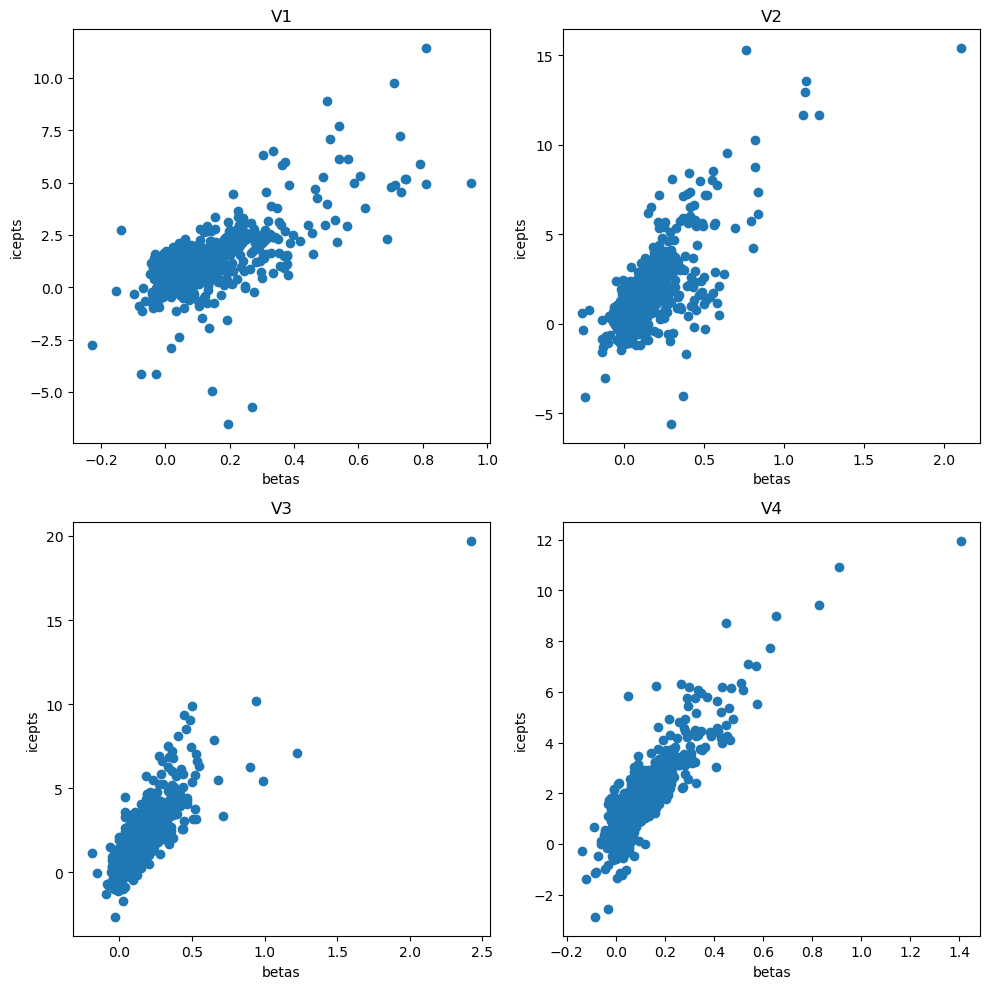

In [299]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

rois = ['V1_mask', 'V2_mask', 'V3_mask', 'V4_mask']

for i, roi in enumerate(rois):
    betas = [reg_dict[roi][vox]['beta'] for vox in reg_dict[roi]]
    icepts = [reg_dict[roi][vox]['icept'] for vox in reg_dict[roi]]
    
    row = i // 2
    col = i % 2
    
    axs[row, col].scatter(betas, icepts)
    axs[row, col].set_xlabel('betas')
    axs[row, col].set_ylabel('icepts')
    axs[row, col].set_title(roi[:2])
    
plt.tight_layout()
plt.show()


/tmp/ipykernel_22721/3830768132.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({'Voxel': [voxel_name], 'Beta': [beta], 'Intercept': [intercept]})])


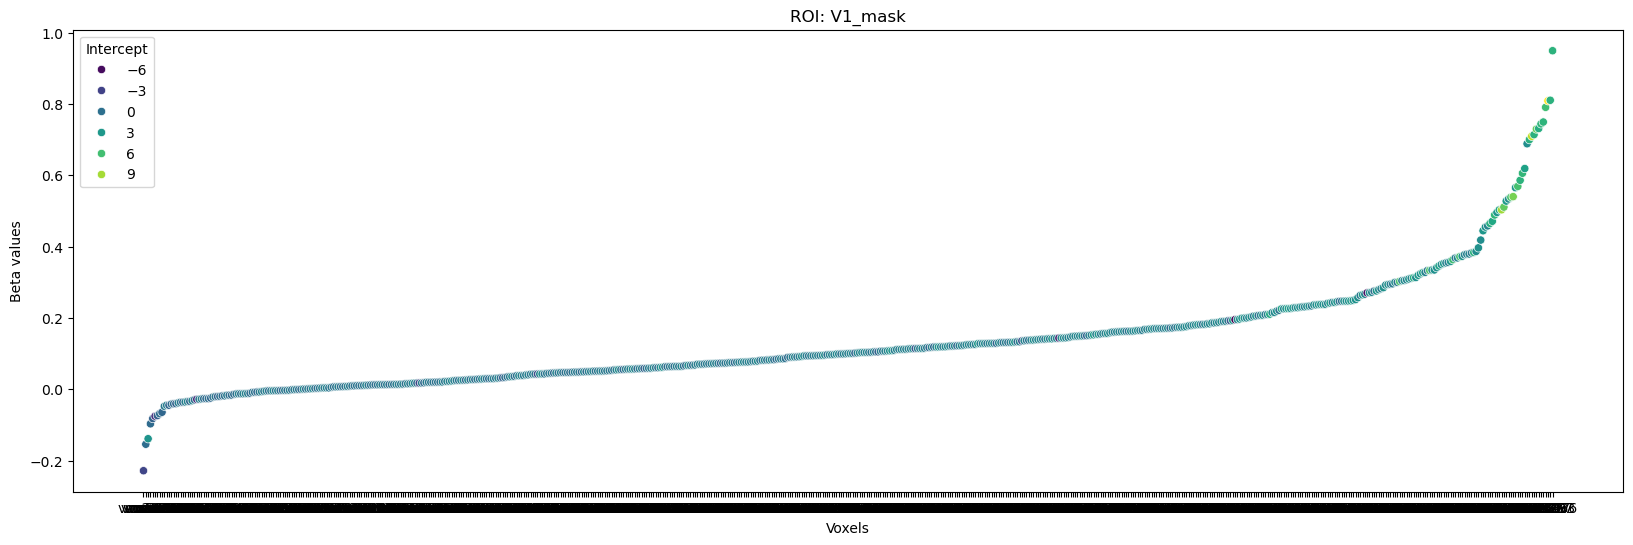

/tmp/ipykernel_22721/3830768132.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({'Voxel': [voxel_name], 'Beta': [beta], 'Intercept': [intercept]})])


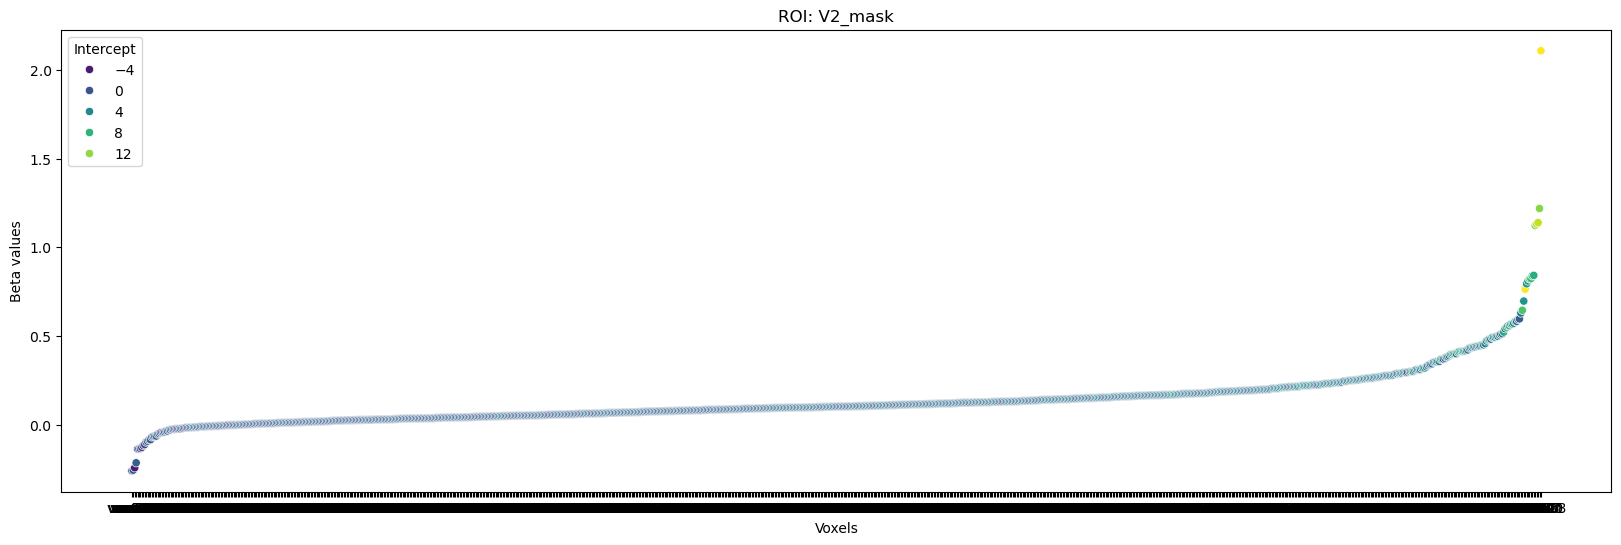

/tmp/ipykernel_22721/3830768132.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({'Voxel': [voxel_name], 'Beta': [beta], 'Intercept': [intercept]})])


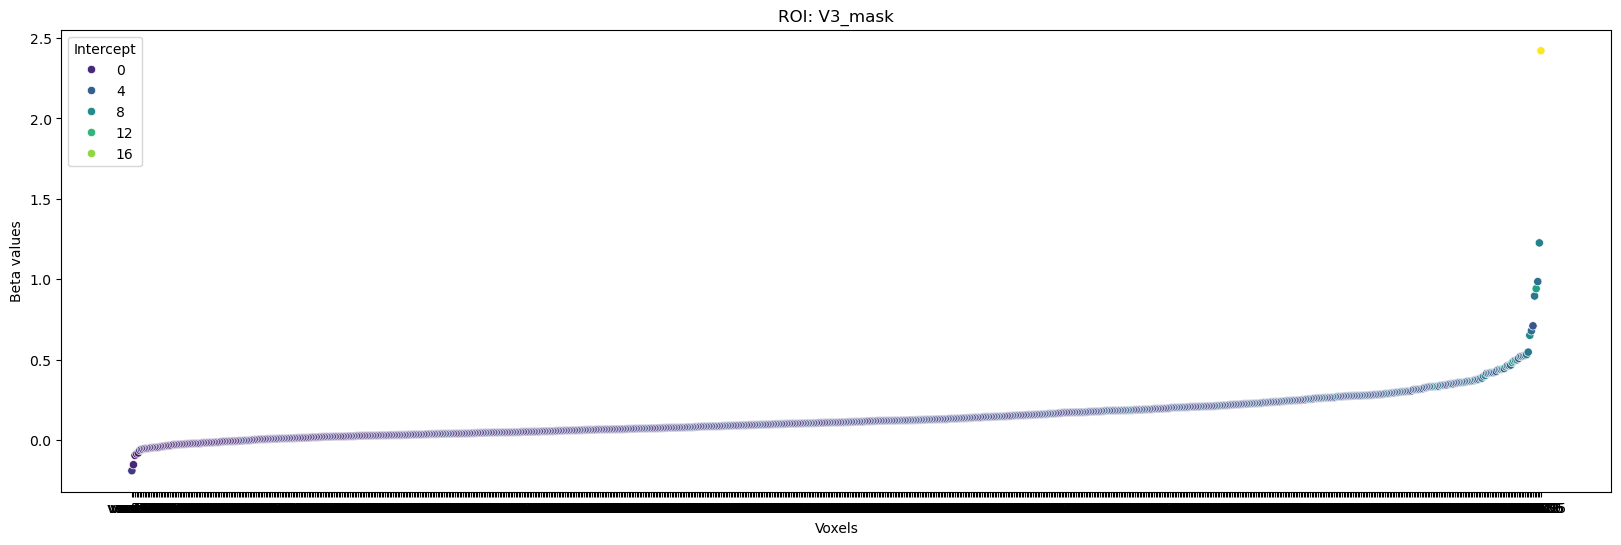

/tmp/ipykernel_22721/3830768132.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({'Voxel': [voxel_name], 'Beta': [beta], 'Intercept': [intercept]})])


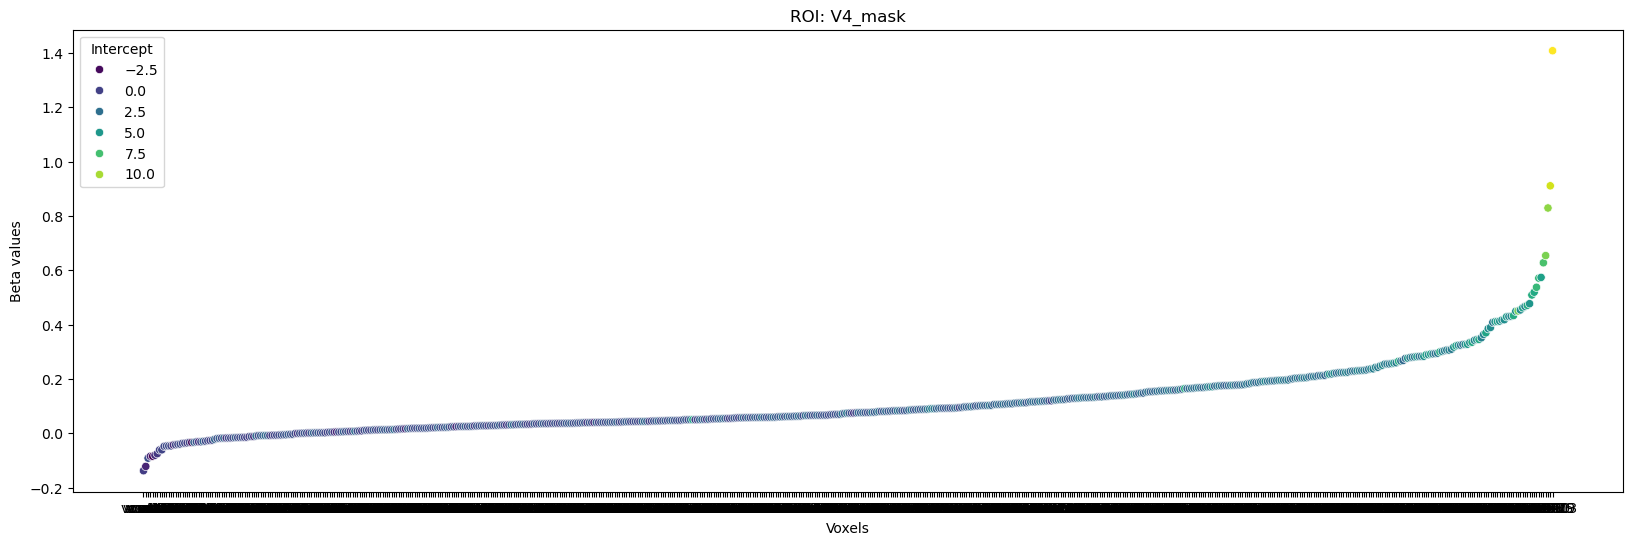

In [405]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def plot_roi_scatter(reg_dict, roi):
    voxels = reg_dict[roi]
    
    # Create a DataFrame where each row corresponds to a voxel
    df = pd.DataFrame(columns=['Voxel', 'Beta', 'Intercept'])
    for voxel_name, voxel_data in voxels.items():
        intercept = voxel_data['icept'].item() if isinstance(voxel_data['icept'], np.ndarray) else voxel_data['icept']
        beta = voxel_data['beta'].item() if isinstance(voxel_data['beta'], np.ndarray) else voxel_data['beta']
        df = pd.concat([df, pd.DataFrame({'Voxel': [voxel_name], 'Beta': [beta], 'Intercept': [intercept]})])  
    
    # Sort the DataFrame by beta values in ascending order
    df = df.sort_values(by='Beta')
    
    plt.figure(figsize=(20, 6))
    sns.scatterplot(data=df, x='Voxel', y='Beta', hue='Intercept', palette='viridis')
    plt.title(f'ROI: {roi}')
    plt.xlabel('Voxels')
    plt.ylabel('Beta values')
    plt.show()
    
    return voxels

# Call the function for each ROI
rois = ['V1_mask', 'V2_mask', 'V3_mask', 'V4_mask']  # replace with your actual ROIs
for roi in rois:
    kont = plot_roi_scatter(reg_dict, roi)

/tmp/ipykernel_22721/4263051743.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({'Voxel': [voxel_name], 'Beta': [beta], 'Intercept': [intercept]})])
/tmp/ipykernel_22721/4263051743.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({'Voxel': [voxel_name], 'Beta': [beta], 'Intercept': [intercept]})])
/tmp/ipykernel_22721/4263051743.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is 

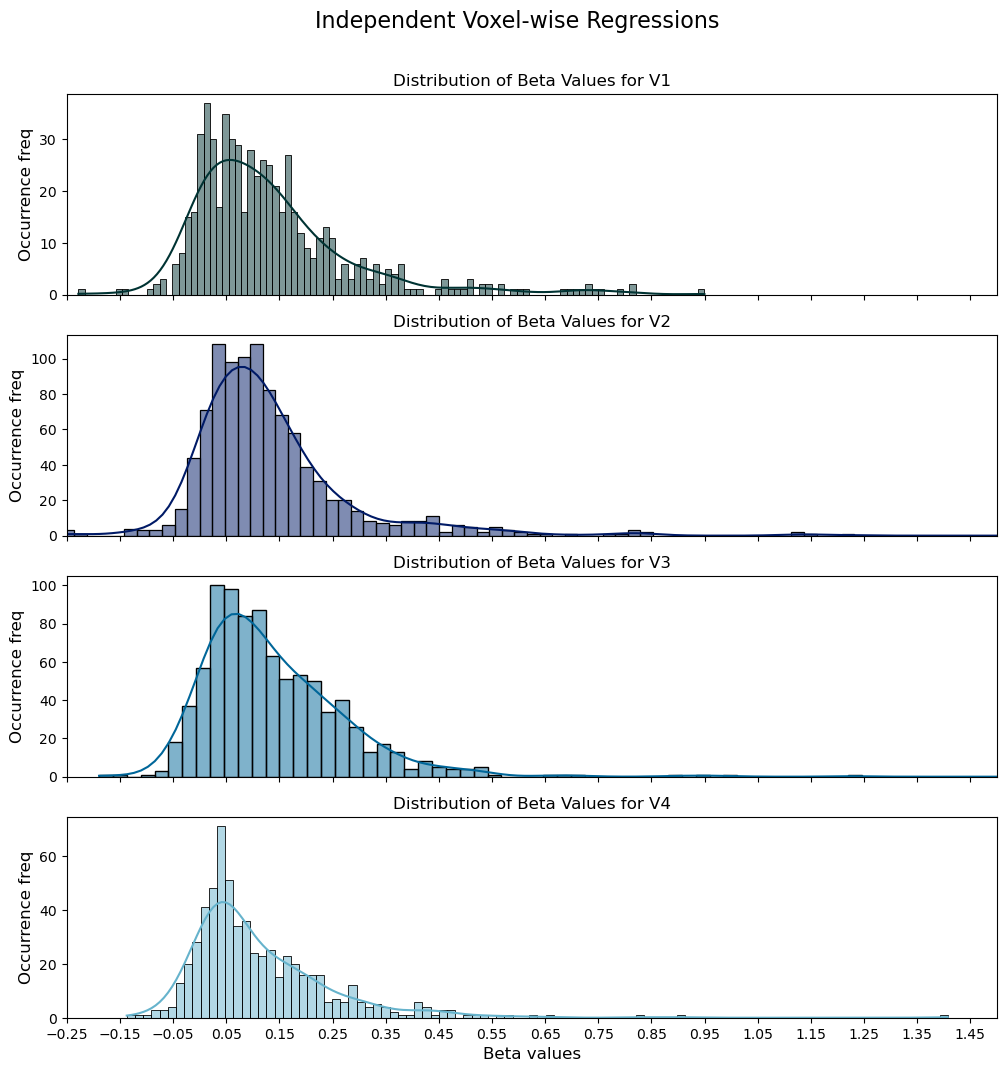

In [481]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_roi_heatmap(reg_dict, roi, ax, color):
    voxels = reg_dict[roi]
    
    # Create a DataFrame where each row corresponds to a voxel
    df = pd.DataFrame(columns=['Voxel', 'Beta', 'Intercept'])
    for voxel_name, voxel_data in voxels.items():
        intercept = voxel_data['icept'].item() if isinstance(voxel_data['icept'], np.ndarray) else voxel_data['icept']
        beta = voxel_data['beta'].item() if isinstance(voxel_data['beta'], np.ndarray) else voxel_data['beta']
        df = pd.concat([df, pd.DataFrame({'Voxel': [voxel_name], 'Beta': [beta], 'Intercept': [intercept]})])  
    
    # Create a histogram to count the frequency of beta values
    sns.histplot(df['Beta'], bins=100, kde=True, color=color, ax=ax)
    ax.set_title(f'Distribution of Beta Values for {roi[:2]}')
    ax.set_xlabel('Beta values', fontsize=12, weight = 'normal')
    ax.set_ylabel('Occurrence freq', weight = 'normal', fontsize=12)
    ax.set_xlim(-0.25, 1.5)  # Set the same x range for all subplots
    ax.set_xticks(np.arange(-0.25, 1.5, 0.1))  # Set the ticks to be more frequent

# Create a single figure with 4 subplots
fig, axs = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

# 'ocean' colormap
colors = sns.color_palette("ocean", n_colors=4)

# Call the function for each ROI with the corresponding subplot and color
rois = ['V1_mask', 'V2_mask', 'V3_mask', 'V4_mask']  # replace with your actual ROIs
for roi, ax, color in zip(rois, axs, colors):
    plot_roi_heatmap(reg_dict, roi, ax, color)

# Add a global title to the figure
fig.suptitle('Independent Voxel-wise Regressions', fontsize=16, y=.95)

plt.show()  # Show the overall figure


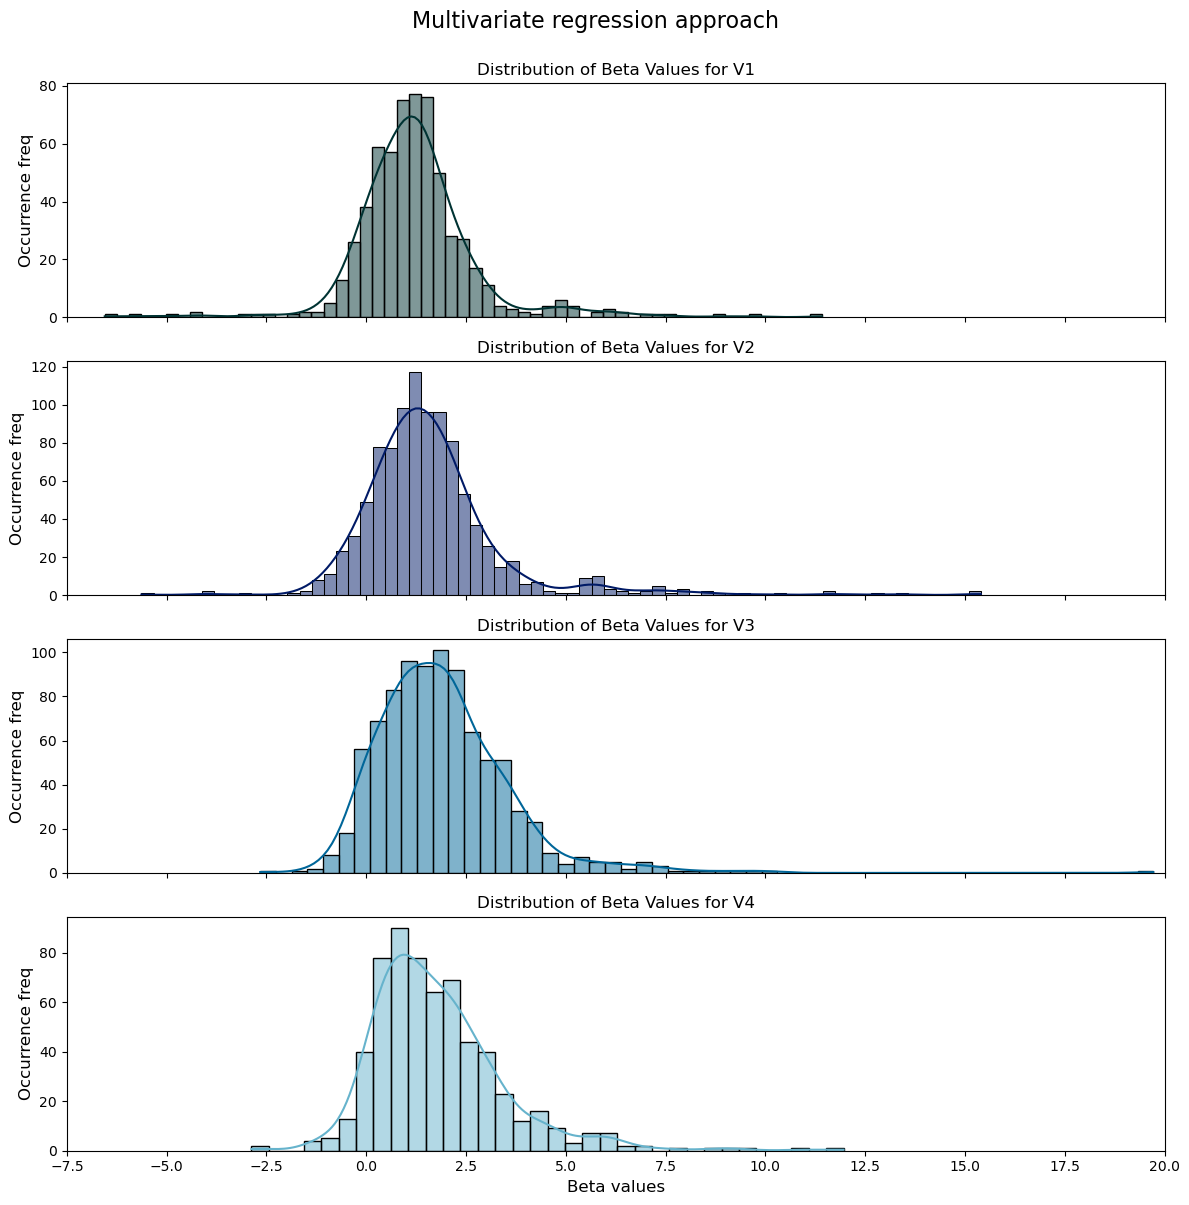

In [482]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def multivariate_regression(X, y_matrix):
    # Add a constant term to the independent variable matrix
    X_with_constant = sm.add_constant(X)

    # Reshape y_matrix to (n_imgs, n_voxels)
    n_imgs, n_voxels = y_matrix.shape
    y_matrix_reshaped = y_matrix.reshape(n_imgs, n_voxels, 1)

    # Fit the multivariate regression model
    model = sm.OLS(y_matrix_reshaped, X_with_constant)
    results = model.fit()

    # Extract beta coefficients and intercepts
    beta_values = results.params[:-1, :]
    intercept_values = results.params[-1, :]

    return beta_values, intercept_values

def regression_dict_multivariate(subject, feat_type, voxels, hrfs, feat_vals, n_imgs='all'):
    reg_dict = {}
    
    # Set the amount of images to regress over in case all images are available.
    if n_imgs == 'all':
        n_imgs = len(feat_vals)
    
    X = np.array(feat_vals[feat_type][:n_imgs]).reshape(n_imgs, 1)  # Set the input matrix for the regression analysis
    
    # This function will run the multiple regression analysis for each voxel, roi, image, for a subject.
    rois = list(voxels[subject].keys())

    for roi in rois:
        reg_dict[roi] = {}
        voxel_mask = voxels[subject][roi]  # These are the boolean mask for the specific subject, roi
        n_voxels = np.sum(voxel_mask).astype('int')  # This is the number of voxels in this roi
        vox_indices = np.column_stack(np.where(voxel_mask == 1))  # Get voxel indices for the current ROI
        
        # Extract y_matrix for all voxels within the ROI
        y_matrix = np.array([hrfs[tuple(vox_idx)][:n_imgs] for vox_idx in vox_indices]).T / 300

        # Perform multivariate regression
        beta_values, intercept_values = multivariate_regression(X, y_matrix)

        for voxel, vox_idx in enumerate(vox_indices):
            reg_dict[roi][f'vox{voxel}'] = {
                'xyz': list(vox_idx),
                'beta': beta_values[:, voxel],
                'icept': intercept_values[voxel]
            }

    return reg_dict, X, y_matrix

def plot_roi_beta_distribution(reg_dict):
    fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)
    colors = sns.color_palette('ocean', n_colors=len(reg_dict))

    for i, (roi, voxels) in enumerate(reg_dict.items()):
        beta_values = np.concatenate([voxel_data['beta'] for voxel_data in voxels.values()])
        sns.histplot(beta_values, kde=True, ax=axes[i], color=colors[i], label=f'{roi} ROI')

        axes[i].set_title(f'Distribution of Beta Values for {roi[:2]}')
        axes[i].set_ylabel('Occurrence freq', weight = 'normal', fontsize = 12)
        axes[i].set_xlim(-5, 20)  # Set the same x range for all subplots

        axes[i].set_xticks(np.arange(-7.5, 22.5, 2.5))  # Set the ticks to be more frequent


    axes[-1].set_xlabel('Beta values', weight = 'normal', fontsize = 12)
    fig.suptitle('Multivariate regression approach', fontsize=16, y=1)

    plt.tight_layout()
    plt.show()

# Example usage
rois_to_plot = ['V1_mask', 'V2_mask', 'V3_mask', 'V4_mask']
reg_dict_multivariate, X_multivariate, y_matrix_multivariate = regression_dict_multivariate('subj01', 'rms_z', prf_selection_mask, betas_ses1, rms_subj01, n_imgs=750)
plot_roi_beta_distribution(reg_dict_multivariate)


In [398]:
for oei, loei in kont.items():
    print((list(loei['icept'].astype('float'))))

[-0.002984739180460634]
[0.09956882943399614]
[-0.20259790142373985]
[2.247394529792952]
[0.2807226564331331]
[0.693867680982386]
[3.3751795345215383]
[0.7501269959138804]
[1.779598421458734]
[1.7960208237810718]
[-0.2661467898311508]
[0.19860699088409167]
[-0.46848503180840745]
[0.5325532518690583]
[0.6779118049299911]
[0.19779256788105112]
[1.3510380018794623]
[1.0978166149423696]
[0.4850932608864532]
[2.109254415947717]
[1.457219301530274]
[1.2433011710071762]
[1.449600547903401]
[1.475546722802269]
[0.3173005516800183]
[0.3850386432468421]
[1.5849959691882949]
[2.298451046344173]
[1.8062145239968819]
[1.7425735909857527]
[2.206950552161327]
[2.031330524618467]
[1.9938968510703083]
[0.9775011850848624]
[0.31394535298225157]
[2.0060403022722295]
[1.8004629499812237]
[1.2534130054672656]
[0.8440818503290825]
[0.29467410290263285]
[-0.26645152980912357]
[3.0198753543707952]
[1.826785950785941]
[0.9158191146615325]
[0.34623140939012903]
[0.17224642582260774]
[2.4100539064706963]
[1.6064

In [313]:
print_dict_structure(reg_dict)

V1_mask
    vox0
        xyz
        beta
        icept
    vox1
        xyz
        beta
        icept
    vox2
        xyz
        beta
        icept
    vox3
        xyz
        beta
        icept
    vox4
        xyz
        beta
        icept
    vox5
        xyz
        beta
        icept
    vox6
        xyz
        beta
        icept
    vox7
        xyz
        beta
        icept
    vox8
        xyz
        beta
        icept
    vox9
        xyz
        beta
        icept
    vox10
        xyz
        beta
        icept
    vox11
        xyz
        beta
        icept
    vox12
        xyz
        beta
        icept
    vox13
        xyz
        beta
        icept
    vox14
        xyz
        beta
        icept
    vox15
        xyz
        beta
        icept
    vox16
        xyz
        beta
        icept
    vox17
        xyz
        beta
        icept
    vox18
        xyz
        beta
        icept
    vox19
        xyz
        beta
        icept
    vox20
        xyz


In [181]:
# prf_selection_mask['subj01']['V1_mask']

# np.where(prf_selection_mask['subj01']['V1_mask'] == True)

In [83]:
# This should be easier, there is definitely an object (probably returned by one of the heatmap functions) that has solely the voxel selection.
# However, this works as well, without any delay actually. So there is not really a reason to simplify the data format again. This has its benefits.
# Such as nifti transformation and plotting.

vox_idx = []
for i in range(3):
   vox_idx = (np.append(vox_idx, np.where(prf_selection_mask['subj01']['V1_mask'] == 1)[i][0])).astype('int')
   
   

In [117]:
# X = list(rms_subj01['rms'][:750])


X = np.array(rms_subj01['rms_z'][:750]).reshape(750,1)

y = (np.array(betas_ses1[vox_idx[0]][vox_idx[1]][vox_idx[2]]).reshape(750, 1))/300




In [118]:
print(X.shape)
print(y.shape)

(750, 1)
(750, 1)


In [120]:
reg = multiple_regression(X, y)

In [121]:
reg

array([[ 0.00009],
       [-0.34503]])

In [118]:
testdf = get_contrast_df(100, start_img_no = 0, roi = 'V1', subject = 'subj01', ecc_max = 1, ecc_strict = 'y', prf_proc_dict = prf_dict, binary_masks = vismask_dict, rf_type = 'center', contrast_type = 'rms_lab')

Processing image number: 0 out of 100
Processing image number: 10 out of 100
Processing image number: 20 out of 100
Processing image number: 30 out of 100
Processing image number: 40 out of 100
Processing image number: 50 out of 100
Processing image number: 60 out of 100
Processing image number: 70 out of 100
Processing image number: 80 out of 100
Processing image number: 90 out of 100


Use these codes to collect the rms values for all the images separately, then later on assign them based on the desing matrices. This saves a lot of time. Check the later code for what is useful and what not. The whole get_contrast_df function should probably be adapted in a way, as it is really not efficient anymore. But it definitely has useful components such as the df creation and uhhhh yeah I guess that's it.

In [12]:
rms_test = rms_all(start = 72998, n = 2)
rms_test

rms
72998  28.464819
72999  18.567823

In [10]:
rms_test.to_pickle('rms_lab_df_20-50k.pkl')
# rms_lab_df_10k.to_pickle('rms_lab_df_10k.pkl')

In [13]:
latest_rms = pd.read_pickle('all_rms_lab_df_72k')
all_rms = pd.DataFrame({'rms': np.append(latest_rms['rms'], rms_test['rms'])})

print(all_rms)
all_rms.to_pickle('all_rms_lab_df')

             rms
0      24.850763
1      66.215949
2      15.592134
3      15.113406
4      32.931833
...          ...
72995  32.597843
72996  19.921272
72997  54.109564
72998  28.464819
72999  18.567823

[73000 rows x 1 columns]


##### THink about whether I need to reduce them to z-scores. I think I need to do that, but I'm not sure actually. Probably yes, because then we've got a universal standardized measure. I've got a function for it anyway, in the utility.py file.

<Axes: >

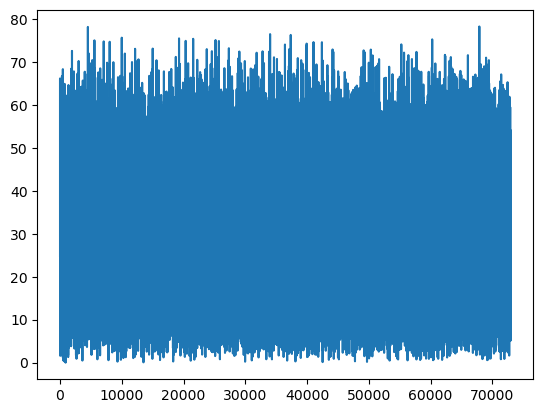

In [15]:
all_rms['rms'].plot()

These RMS values have been collected based on the LAB lightness, or luminance values. This is postulated as being the best representative for human visual perception.

Yes and it is very slow. This took more than an hour, and now I've got a version that does the same in 10 min.

In [5]:
rms_lab_df_10k = get_contrast_df(10000, start_img_no = 0, roi = 'V1', subject = 'subj01', ecc_max = 1, ecc_strict = 'y', prf_proc_dict = prf_dict, binary_masks = vismask_dict, rf_type = 'center')
rms_lab_df_10k.to_pickle('rms_lab_df_10k.pkl')

Processing image number: 0 out of 10000
Processing image number: 10 out of 10000
Processing image number: 20 out of 10000
Processing image number: 30 out of 10000
Processing image number: 40 out of 10000
Processing image number: 50 out of 10000
Processing image number: 60 out of 10000
Processing image number: 70 out of 10000
Processing image number: 80 out of 10000
Processing image number: 90 out of 10000
Processing image number: 100 out of 10000
Processing image number: 110 out of 10000
Processing image number: 120 out of 10000
Processing image number: 130 out of 10000
Processing image number: 140 out of 10000
Processing image number: 150 out of 10000
Processing image number: 160 out of 10000
Processing image number: 170 out of 10000
Processing image number: 180 out of 10000
Processing image number: 190 out of 10000
Processing image number: 200 out of 10000
Processing image number: 210 out of 10000
Processing image number: 220 out of 10000
Processing image number: 230 out of 10000
Pro

In [212]:
rms_lab_subj01 = pd.read_pickle('/home/rfpred/rms_lab_df_10k.pkl')
rms_lab_subj01.shape[0]

# Standardize the root mean square values by turning them into z-scores
# rms_lab_z = get_zscore(rms_lab_subj01['rms'], print_ars = 'n')
# rms_lab_subj01['rms'] = rms_lab_z

rms_lab_subj01['image_id'][0]

rms_lab_subj01[000:100]

rms  image_id subject  central_radius
0   24.850763     46002  subj01               1
1   66.215949     61882  subj01               1
2   15.592134       828  subj01               1
3   15.113406     67573  subj01               1
4   32.931833     16020  subj01               1
..        ...       ...     ...             ...
95   9.153318     50102  subj01               1
96  49.319350     21683  subj01               1
97  30.953718     31968  subj01               1
98  44.166184     25260  subj01               1
99  14.879705     11880  subj01               1

[100 rows x 4 columns]

#### The following 3 code sections involve the old RMS computations

These are wrong, as the values do not correspond with the image_id, but actually only with the first 30.000 images of the 73.000 dataset. not very useful at all.

In [205]:
all_rms = pd.DataFrame({'rms': np.append(rms_lab_subj01['rms'], rms_test['rms'])})

print(all_rms)
# all_rms.to_pickle('all_rms_lab_df_20k')

             rms
0      24.850763
1      66.215949
2      15.592134
3      15.113406
4      32.931833
...          ...
19995  30.471547
19996  43.315133
19997  28.705528
19998  11.648056
19999  24.322731

[20000 rows x 1 columns]


In [78]:
rms_subj01 = pd.read_pickle('/home/rfpred/rms_df_subj01.pkl')
rms_subj01.shape[0]

30000

In [6]:
# Standardize the root mean square values by turning them into z-scores
rms_z = get_zscore(rms_subj01['rms'], print_ars = 'n')
rms_subj01['rms'] = rms_z

In [79]:
rms_subj01


rms  image_id roi subject
0      23.642583     46002  V1  subj01
1      63.647350     61882  V1  subj01
2      15.106963       828  V1  subj01
3      15.123642     67573  V1  subj01
4      32.203252     16020  V1  subj01
...          ...       ...  ..     ...
29995  28.400372     13773  V1  subj01
29996  33.316182     66767  V1  subj01
29997  33.374350     53167  V1  subj01
29998  46.894380      1943  V1  subj01
29999   6.231007      5033  V1  subj01

[30000 rows x 4 columns]

In [95]:
def get_contrast_df(n_images = None, start_img_no = 0 ,roi = 'V1', subject = 'subj01', ecc_max = 1, ecc_strict = 'y', 
                     prf_proc_dict = None, binary_masks = None, rf_type = 'prf', contrast_type = 'rms_lab'):
    
    designmx = get_imgs_designmx()
    
    if n_images == 'all':
        n_images = len(designmx['subj01'])
    
    indices, rms_list, image_id_list= [], [], []
      
    img_vec = designmx[subject][start_img_no : n_images + start_img_no]  
    
    # for img_no in range(start_img_no, n_images + start_img_no):
    for n_img, img_id in enumerate(img_vec):
        ar_in = show_stim(img_no = img_id, hide = 'y')[0]
        
        if rf_type == 'prf':
            # Acquire mask based on subject, roi, outline. Type is cut_gaussian by default, based on NSD paper
            rf_info = get_mask(dim = 425, subject = subject, binary_masks = binary_masks, 
                                            prf_proc_dict = prf_proc_dict, type='cut_gaussian', roi=roi,
                                            plot = 'n', excl_reason = 'n', sigma_min=0, sigma_max = 4.2, 
                                            ecc_max = ecc_max, ecc_strict = ecc_strict)
            
            # Get the location and radius of the patch
            x, y = rf_info['x'].astype('int'), rf_info['y'].astype('int')
            radius = rf_info['pix_radius'].astype('int')
            mask_w_in = rf_info['mask']
            
            # Create boolean mask of exact same size as weighted pRF patch
            rf_mask_in = make_circle_mask(425, x, y, radius, fill = 'y', margin_width = 0)
            
        elif rf_type == 'center':
            dim = ar_in.shape[0]
            x = y = (dim + 1)/2
            radius = ecc_max * (dim / 8.4)
            mask_w_in = css_gaussian_cut(dim, x, y, radius)
            rf_mask_in = make_circle_mask(dim, x, y, radius, fill = 'y', margin_width = 0)
            
        # Get root mean square contrast of image and add to list
        indices.append(n_img)
        
        if contrast_type == 'rms_lab':
            rms_list.append(get_rms_contrast_lab(ar_in, mask_w_in, rf_mask_in, normalise = True, plot = 'n'))
        elif contrast_type == 'rms':
            rms_list.append(get_rms_contrast(ar_in, mask_w_in, rf_mask_in, normalise = True, plot = 'n'))
            
        # rms_list.append(get_rms_contrast(ar_in, mask_w_in, rf_mask_in, normalise = True))
        image_id_list.append(designmx[subject][n_img])
        # roi_list.append(roi)
        # subject_list.append(subject)
        if n_img % 10 == 0:
            print(f"Processing image number: {n_img} out of {n_images + start_img_no}")

    contrast_df = pd.DataFrame({
        'rms': rms_list,
        'image_id': image_id_list
        # 'roi': roi_list,
        # 'subject': subject_list
    })
    
    # Remove this roi thing, or well, only when rf_type = 'center'
    # contrast_df.insert(2, 'roi', [roi] * contrast_df.shape[0])
    contrast_df.insert(2, 'subject', [subject] * contrast_df.shape[0])
    contrast_df.insert(3, 'central_radius', [ecc_max] * contrast_df.shape[0])
    
    contrast_df = contrast_df.set_index(np.array(indices))
    
    return contrast_df

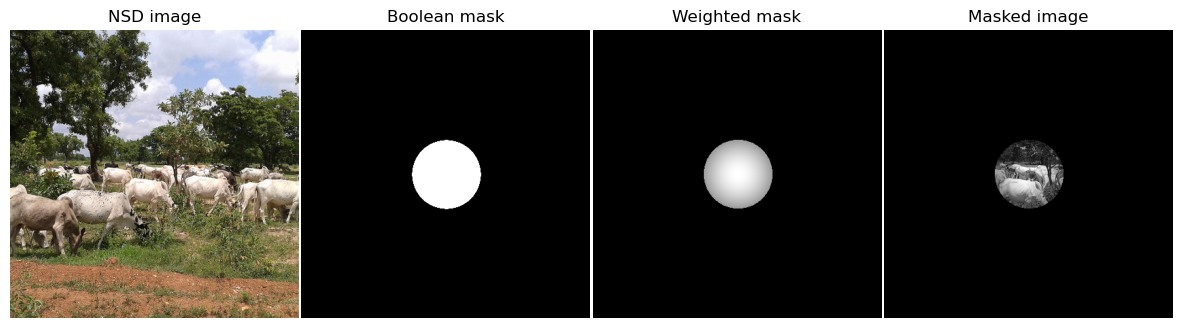

In [19]:
# Choose image from the natural scenes dataset
img_no = 46002 #29

img = show_stim(img_no = img_no, hide = 'y')[0]

# Create the mask and acquire relevant parameters.
info = get_mask(dim = 425, subject = 'subj01', binary_masks = vismask_dict, 
                                        prf_proc_dict = prf_dict, type='outline', roi='V2',
                                        plot = 'n', excl_reason = 'n', sigma_min=0, sigma_max = 1.2, 
                                        ecc_max = 1, fill_outline = 'y', grid = 'y')

weighted_mask = css_gaussian_cut(425, 213, 213, (425/8.4))

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
plt.subplots_adjust(wspace=0.01)

# Plot the first image in the first subplot
axs[0].imshow(img)
axs[0].set_title('NSD image')
axs[0].axis('off') 
# Plot the second image in the second subplot
axs[2].imshow(weighted_mask, cmap = 'gist_gray')
axs[2].set_title('Weighted mask')
axs[2].axis('off') 
axs[1].imshow(info['mask'], cmap = 'gist_gray')
axs[1].set_title('Boolean mask')
axs[1].axis('off') 

# Plot the weighted masked image in the fourth subplot
weighted_masked_image = np.multiply(np.mean(img, axis = -1), weighted_mask)
axs[3].imshow(weighted_masked_image, cmap = 'gist_gray')
axs[3].set_title('Masked image')
axs[3].axis('off') 
plt.show()


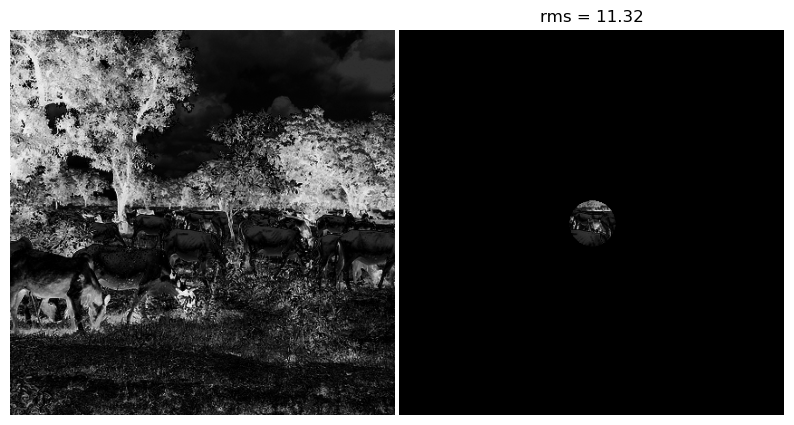

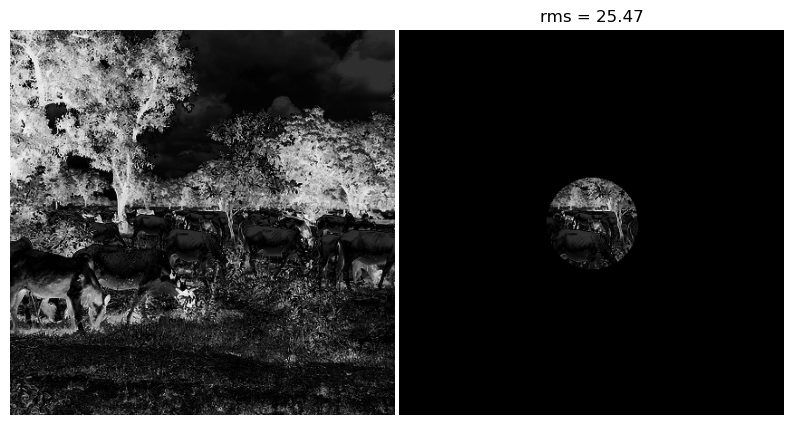

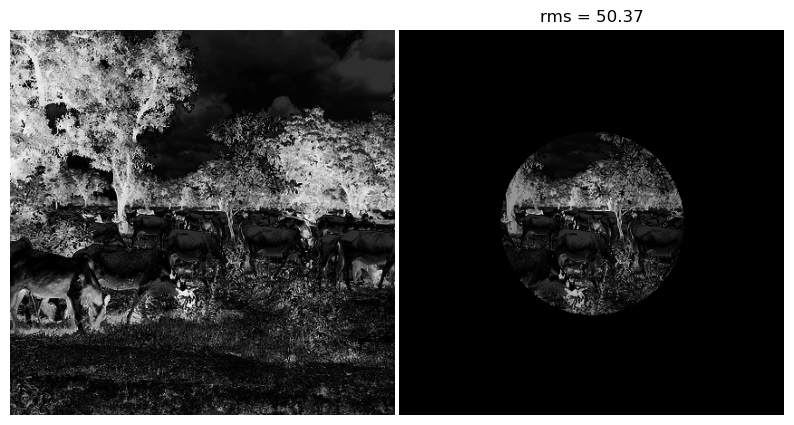

In [20]:
# This is when using the L parameter of the LAB colour space, which is the luminance channel. Best to use.
# Check to see whether my function actually exclusively calculates the RMS of the patch. It does.

tiny = get_rms_contrast_lab(img, css_gaussian_cut(425, 213, 213, (425/16.8)), info['mask'], normalise = True, plot = 'y')

small = get_rms_contrast_lab(img, css_gaussian_cut(425, 213, 213, (425/8.4)), info['mask'], normalise = True, plot = 'y')

big = get_rms_contrast_lab(img, css_gaussian_cut(425, 213, 213, (425/4.2)), info['mask'], normalise = True, plot = 'y')

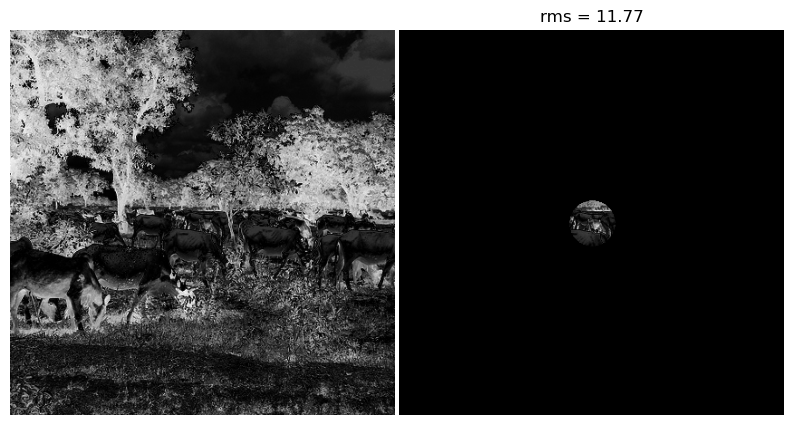

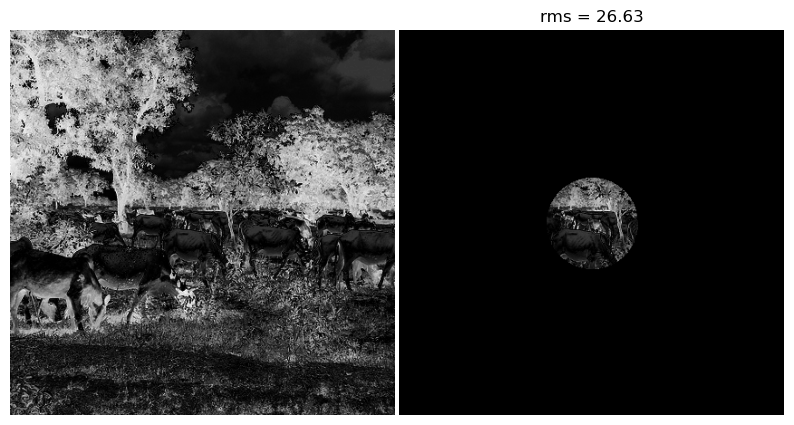

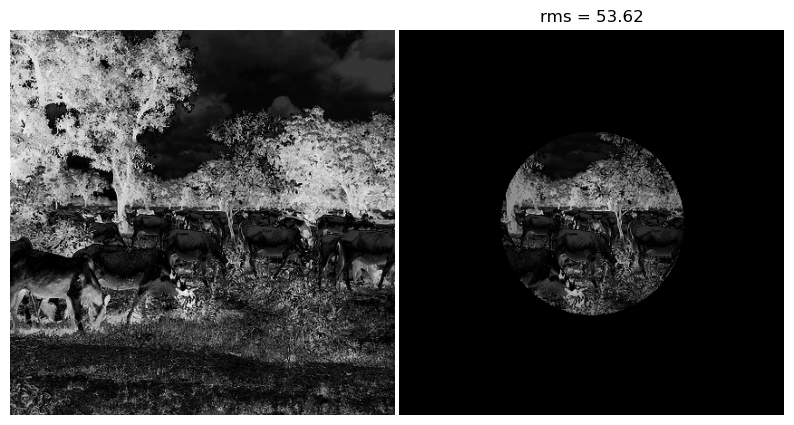

In [21]:
# This is the original RMS function, which does not use the lightness parameter. The differences are minute.
# Check to see whether my function actually exclusively calculates the RMS of the patch. It does.

tiny = get_rms_contrast(img, css_gaussian_cut(425, 213, 213, (425/16.8)), info['mask'], normalise = True, plot = 'y')

small = get_rms_contrast(img, css_gaussian_cut(425, 213, 213, (425/8.4)), info['mask'], normalise = True, plot = 'y')

big = get_rms_contrast(img, css_gaussian_cut(425, 213, 213, (425/4.2)), info['mask'], normalise = True, plot = 'y')